# Data Analysis
Now that the data is uploaded to the Neo4j server, we can use the same py2neo package to make queries to the database

## Overview
First, let's just take a look at some basic metrics about our data: Total number of Nodes, breakdown of comics vs heroes, and how many edges our graph has.

In [1]:
from py2neo import Graph
import time
import networkx as nx
import matplotlib.pyplot as plt

import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx


# Connect to the Neo4j database
graph = Graph("bolt://neo4j:7687", auth=("neo4j", "1234"))

# Count nodes
total_nodes_count = graph.evaluate("MATCH (n) RETURN count(n)")
hero_nodes_count = graph.evaluate("MATCH (n:hero) RETURN count(n)")
comic_nodes_count = graph.evaluate("MATCH (n:comic) RETURN count(n)")

print(f"Total nodes count: {total_nodes_count}")
print(f"Hero nodes count: {hero_nodes_count}")
print(f"Comic nodes count: {comic_nodes_count}")

# Count edges
total_edges_count = graph.evaluate("MATCH ()-[r]->() RETURN count(r)")
print(f"Total edges count: {total_edges_count}")


Total nodes count: 19090
Hero nodes count: 6439
Comic nodes count: 12651
Total edges count: 94527


### Timing Function
Let's also define a function to time how long our queries take: 

In [2]:
# Function to execute a Cypher query and measure execution time
def execute_query(query):
    start_time = time.time()
    result = graph.run(query).data()
    end_time = time.time()
    completion_time = end_time - start_time
    return result, completion_time

## Most Common Heroes
Let's take a look at which heroes appear in the most stories, by querying the database for which node's of `type = 'hero'` have the most relationships

In [3]:

# Find the nodes of type 'hero' with the most connections
query = """
MATCH (hero:hero)--(connected)
RETURN hero.name AS hero_name, COUNT(connected) AS connection_count
ORDER BY connection_count DESC
LIMIT 20
"""

result, completion_time = execute_query(query)

print("Heroes with the most comic book appearances:")
for idx, record in enumerate(result, start=1):
    hero_name = record['hero_name']
    connection_count = record['connection_count']
    print(f"   {idx}. Hero: {hero_name}, Comic Count: {connection_count}")

print(f"Execution time: {completion_time:.2f} seconds")

Heroes with the most comic book appearances:
   1. Hero: CAPTAIN AMERICA, Comic Count: 1334
   2. Hero: IRON MAN/TONY STARK, Comic Count: 1150
   3. Hero: THING/BENJAMIN J. GR, Comic Count: 963
   4. Hero: THOR/DR. DONALD BLAK, Comic Count: 956
   5. Hero: HUMAN TORCH/JOHNNY S, Comic Count: 886
   6. Hero: MR. FANTASTIC/REED R, Comic Count: 854
   7. Hero: HULK/DR. ROBERT BRUC, Comic Count: 835
   8. Hero: WOLVERINE/LOGAN, Comic Count: 819
   9. Hero: INVISIBLE WOMAN/SUE, Comic Count: 762
   10. Hero: SCARLET WITCH/WANDA, Comic Count: 643
   11. Hero: BEAST/HENRY &HANK& P, Comic Count: 635
   12. Hero: DR. STRANGE/STEPHEN, Comic Count: 631
   13. Hero: WATSON-PARKER, MARY, Comic Count: 622
   14. Hero: DAREDEVIL/MATT MURDO, Comic Count: 619
   15. Hero: HAWK, Comic Count: 605
   16. Hero: VISION, Comic Count: 603
   17. Hero: CYCLOPS/SCOTT SUMMER, Comic Count: 585
   18. Hero: WASP/JANET VAN DYNE, Comic Count: 581
   19. Hero: JAMESON, J. JONAH, Comic Count: 577
   20. Hero: ANT-MAN/DR

## Captain America's Social Network
Now let's take a look at our most popular hero- Captain America. We'll query the database to find how many different comic's he's appeared in, how many different heroes he's appeared with, and which of those heroes he has appeared with most often.

In [4]:
# 1. How many nodes is 'CAPTAIN AMERICA' connected to
query1 = """
MATCH (ca:hero {name: 'CAPTAIN AMERICA'})--(connected)
RETURN count(DISTINCT connected) AS connected_nodes_count
"""

result1, completion_time1 = execute_query(query1)
connected_nodes_count = result1[0]['connected_nodes_count']
print(f"1. 'CAPTAIN AMERICA' is appears in {connected_nodes_count} comics.")
print(f"   Execution time: {completion_time1:.2f} seconds")

# 2. How many unique nodes are connected to nodes which are connected to 'CAPTAIN AMERICA'
query2 = """
MATCH (ca:hero {name: 'CAPTAIN AMERICA'})--(connected)--(connected_to_connected)
WHERE connected <> connected_to_connected
RETURN count(DISTINCT connected_to_connected) AS unique_connected_nodes_count
"""

result2, completion_time2 = execute_query(query2)
unique_connected_nodes_count = result2[0]['unique_connected_nodes_count']
print(f"2. There are {unique_connected_nodes_count} unique heroes which have appeared in the same comic as Captain America.")
print(f"   Execution time: {completion_time2:.2f} seconds")

# 3. What nodes appear most frequently in the second order connections
query3 = """
MATCH (ca:hero {name: 'CAPTAIN AMERICA'})--(connected)--(connected_to_connected)
WHERE connected <> connected_to_connected
WITH connected_to_connected, COUNT(connected_to_connected) AS freq
RETURN connected_to_connected.name AS node, freq
ORDER BY freq DESC
LIMIT 20
"""

result3, completion_time3 = execute_query(query3)
print("3. Captain America's Most Frequent Collaborators:")
for idx, record in enumerate(result3, start=1):
    node_name = record['node']
    frequency = record['freq']
    print(f"   {idx}. Hero: {node_name}, Co-Appearances: {frequency}")

print(f"   Execution time: {completion_time3:.2f} seconds")


1. 'CAPTAIN AMERICA' is appears in 1334 comics.
   Execution time: 0.05 seconds
2. There are 1918 unique heroes which have appeared in the same comic as Captain America.
   Execution time: 0.09 seconds
3. Captain America's Most Frequent Collaborators:
   1. Hero: IRON MAN/TONY STARK, Co-Appearances: 440
   2. Hero: VISION, Co-Appearances: 385
   3. Hero: THOR/DR. DONALD BLAK, Co-Appearances: 380
   4. Hero: WASP/JANET VAN DYNE, Co-Appearances: 376
   5. Hero: SCARLET WITCH/WANDA, Co-Appearances: 373
   6. Hero: HAWK, Co-Appearances: 319
   7. Hero: ANT-MAN/DR. HENRY J., Co-Appearances: 289
   8. Hero: JARVIS, EDWIN, Co-Appearances: 246
   9. Hero: WONDER MAN/SIMON WIL, Co-Appearances: 215
   10. Hero: FALCON/SAM WILSON, Co-Appearances: 189
   11. Hero: HERCULES [GREEK GOD], Co-Appearances: 183
   12. Hero: SHE-HULK/JENNIFER WA, Co-Appearances: 172
   13. Hero: THING/BENJAMIN J. GR, Co-Appearances: 170
   14. Hero: BEAST/HENRY &HANK& P, Co-Appearances: 169
   15. Hero: MR. FANTASTIC/REE

## Visualizing Captain America's Social Network
Next, we'll show how we can pull data from the Neo4j database and use other packages like NetworkX to do data visualizatio.

Since the Captain appears in so many comics with so many different heroes, let's just look at a few to get a clearer visualization and see how the tools work.

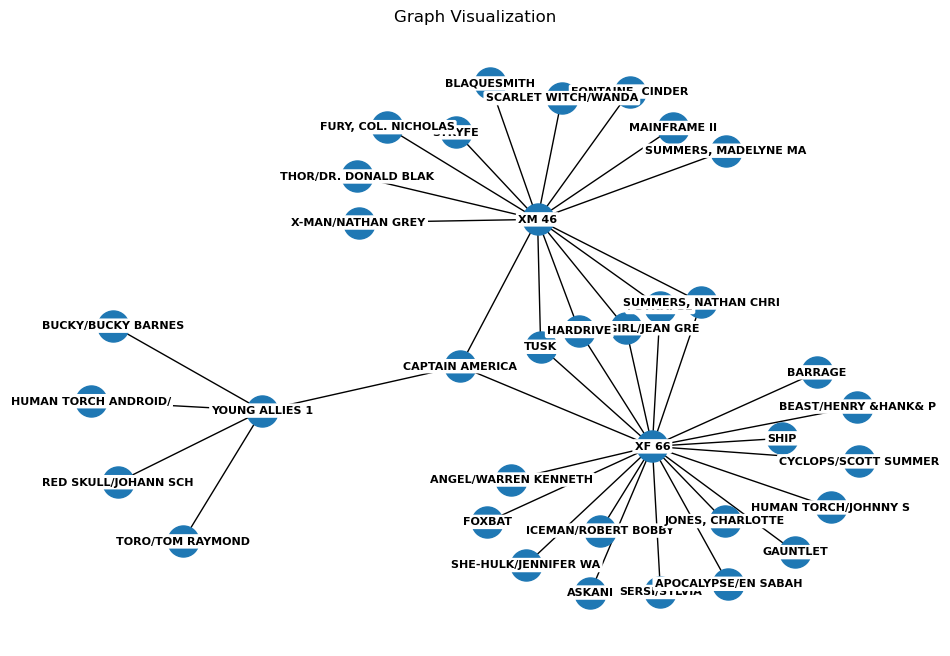

In [5]:
# Retrieve a few random nodes connected to 'CAPTAIN AMERICA' and all nodes connected to those random choices
query_random_nodes = """
MATCH (ca:hero {name: 'CAPTAIN AMERICA'})--(connected)
WITH connected, rand() AS random
ORDER BY random
LIMIT 3
MATCH (connected)--(connected_to_connected)
RETURN connected.name AS node, connected_to_connected.name AS connected_node
"""

result_random_nodes, _ = execute_query(query_random_nodes)

# Extract the node names from the result
nodes = set()
edges = []
for record in result_random_nodes:
    node_name = record['node']
    connected_node_name = record['connected_node']
    nodes.add(node_name)
    nodes.add(connected_node_name)
    edges.append((node_name, connected_node_name))

# Create a graph and add nodes and edges
G = nx.Graph()

# Add nodes and edges
for node in nodes:
    G.add_node(node)
for edge in edges:
    G.add_edge(*edge)

# Visualize the graph
plt.figure(figsize=(12, 8))

pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Graph Visualization")
plt.axis('off')
plt.show()


## Network of Most Popular Heroes
Lastly, let's take a look at a weighted network showing which of our top 20 appearing heroes have appeared together most often.

/tmp/ipykernel_836/2376862263.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu')


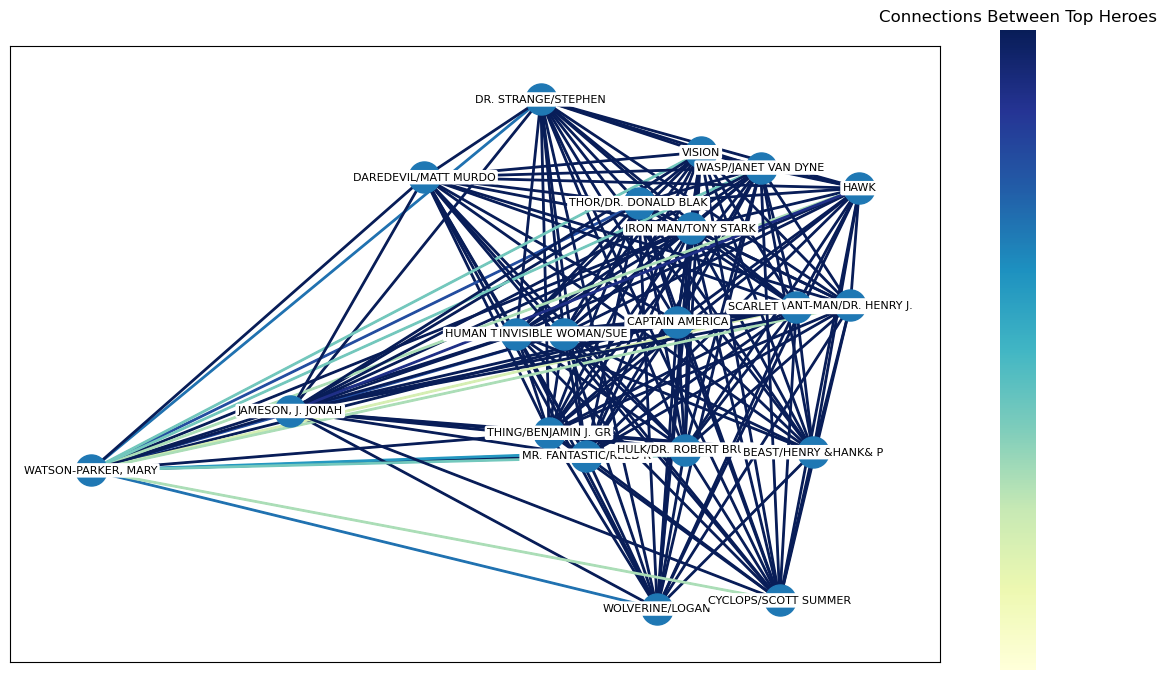

Top 5 Hero Pairs by Connection Count:
THING/BENJAMIN J. GR - HUMAN TORCH/JOHNNY S: 724 connections
HUMAN TORCH/JOHNNY S - MR. FANTASTIC/REED R: 694 connections
THING/BENJAMIN J. GR - MR. FANTASTIC/REED R: 690 connections
MR. FANTASTIC/REED R - INVISIBLE WOMAN/SUE: 682 connections
HUMAN TORCH/JOHNNY S - INVISIBLE WOMAN/SUE: 675 connections


In [6]:
# Retrieve the top heroes
top_heroes = [record['hero_name'] for record in result]

# Count connections between pairs of heroes through intermediate nodes
hero_pairs_connections = {}

for hero1, hero2 in itertools.combinations(top_heroes, 2):
    query_connections_between_heroes = f"""
    MATCH path = (hero1:hero {{name: '{hero1}'}})-[*2]-(hero2:hero {{name: '{hero2}'}})
    WHERE length(path) = 2
    RETURN count(path) AS connection_count
    """

    result_connections_between_heroes, _ = execute_query(query_connections_between_heroes)
    connection_count = result_connections_between_heroes[0]['connection_count']
    hero_pairs_connections[(hero1, hero2)] = connection_count

# Create a graph
G = nx.Graph()

# Add nodes
for hero in top_heroes:
    G.add_node(hero)

# Add edges
for hero_pair, connection_count in hero_pairs_connections.items():
    hero1, hero2 = hero_pair
    G.add_edge(hero1, hero2, weight=connection_count)

# Visualize the graph with node labels smaller and weights distinguished by color
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

# Define colormap
cmap = cm.get_cmap('YlGnBu')

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos)

# Draw node labels with white background boxes and smaller font size
node_labels = nx.draw_networkx_labels(G, pos, font_size=8, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

# Draw edges with colors based on weights
for edge, weight in nx.get_edge_attributes(G, 'weight').items():
    nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=cmap(weight / 10), width=2)

# Create a separate Axes object for the colorbar
cax = plt.axes([0.95, 0.1, 0.03, 0.8])  # [left, bottom, width, height]

# Add legend for edge colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=10))
sm._A = []
cbar = plt.colorbar(sm, cax=cax, label='Connection Count')
cbar.ax.tick_params(labelsize=8)

# Adjust colorbar ticks
cbar.set_ticks(range(0, 11))

plt.title("Connections Between Top Heroes")
plt.axis('off')
plt.show()

# Find the top 5 pairs by weight
top_pairs = sorted(hero_pairs_connections.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 pairs with their connection counts
print("Top 5 Hero Pairs by Connection Count:")
for pair, count in top_pairs:
    hero1, hero2 = pair
    print(f"{hero1} - {hero2}: {count} connections")